In [1]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble,\
                    neural_network, svm, decomposition, manifold
from rulefit import RuleFit
import statsmodels.api as sm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

This dataset contains infomration about flights in the USA. The goal is to predict the delay (and if it occur) based on the available data.

In [54]:
aad18_df = pd.read_csv("../data/aa-domestic-delays-2018.csv", sep=",")
aad18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             899527 non-null  float64
 7   DEP_AFPH              899527 non-null  float64
 8   DEP_RFPH              899527 non-null  float64
 9   TAXI_OUT              899527 non-null  float64
 10  WHEELS_OFF            899527 non-null  float64
 11  CRS_ELAPSED_TIME      899527 non-null  float64
 12  PCT_ELAPSED_TIME      899527 non-null  float64
 13  DISTANCE              899527 non-null  float64
 14  CRS_ARR_TIME          899527 non-null  int64  
 15  

## Data preprocessing

Time and date features

In [3]:
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

Extracting hubs

In [4]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']
#Boolean series for if ORIGIN or DEST are hubs
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)
#Use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1
#Delete columns with codes
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

Two types of the delay, ARR is not avoidable and CARRIER is due to the fault of the carrier. We are interested in the second one.

In [5]:
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(10)

,ARR_DELAY,CARRIER_DELAY
8,168.0,136.0
16,20.0,5.0
18,242.0,242.0
19,62.0,62.0
22,19.0,19.0
26,26.0,0.0
29,77.0,77.0
32,19.0,19.0
33,18.0,1.0
40,36.0,16.0


In [ ]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)

### Train test split

We have to problems:

* regression for predicting how big delay will be
* classification telling if delay will occur (it will be equal or greater than 15 minutes)

In [6]:
rand = 9
y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

### Correlation between features and target value

In [7]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_DELAY              0.670182
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
ORIGIN_HUB             0.015334
DEST_HUB               0.013932
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

## Reviewing Traditional Model Interpretation Methods

### Predicting Minutes Delayed with Various Regression Methods

In [8]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()}, 
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)}, 
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)}, 
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, 
                                                   early_stopping=True, random_state=rand)}
    }

In [9]:
for model_name in reg_models.keys():
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

/home/keren/.cache/pypoetry/virtualenvs/_interpretable_machine_learning_with_pytho-_K6fZrxh-py3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/keren/.cache/pypoetry/virtualenvs/_interpretable_machine_learning_with_pytho-_K6fZrxh-py3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/keren/.cache/pypoetry/virtualenvs/_interpretable_machine_learning_with_pytho-_K6fZrxh-py3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/keren/.cache/pypoetry/virtualenvs/_interpretable_machine_learning_with_pytho-_K6fZrxh-py3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names

In [10]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
mlp,0.810956,0.822054,0.999199
random_forest,4.926102,5.918171,0.958486
linear_poly,5.992684,6.128840,0.955477
linear_interact,6.084923,6.220611,0.954134
linear,7.532241,7.593469,0.931655
ridge,7.532241,7.593471,0.931655
decision_tree,6.280440,7.802189,0.927847
rulefit,9.073793,9.010513,0.903767
knn,7.232363,9.028951,0.903373


### Classifying Flights as Delayed or Not Delayed with Various Classification Methods

In [12]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression()}, 
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},  
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)}, 
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                                 class_weight='balanced', random_state=rand)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

Imbalanced classification

In [11]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0])

0.061283264255549


In [13]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train.values)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test.values) 
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = 0
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

/home/keren/.cache/pypoetry/virtualenvs/_interpretable_machine_learning_with_pytho-_K6fZrxh-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/keren/.cache/pypoetry/virtualenvs/_interpretable_machine_learning_with_pytho-_K6fZrxh-py3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/keren/.cache/pypoetry/virtualenvs/_interpretable_machine_learning_with_pytho-_K6fZrxh-py3.11/lib/python3.11/site-packages/skle

In [14]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.999847,0.999822,0.999274,0.998911,0.999998,0.998548,0.998453
gradient_boosting,0.995789,0.995783,0.935719,0.934883,0.999793,0.964475,0.962781
random_forest,0.960023,0.960483,0.999808,0.995159,0.998245,0.755143,0.761399
decision_tree,0.990761,0.990499,0.902981,0.899177,0.997823,0.920570,0.915813
logistic,0.981248,0.980968,0.775658,0.772573,0.980795,0.832529,0.825300
knn,0.974381,0.966301,0.703929,0.629993,0.955788,0.695995,0.682570
naive_bayes,0.925860,0.926555,0.329961,0.326918,0.853971,0.352795,0.315233
ridge,0.888774,0.889328,0.782530,0.782861,0.000000,0.464172,0.462027


### ROC curve

Plot shows the proportion of the true postive rate (recall) on the x axis and the false positive rate on the y axis. AUC is an area under curve and i assess the preidiction ability of the classifier being perfect (value of 1), random (value of 0.5) or worse than random (values below 0.5).

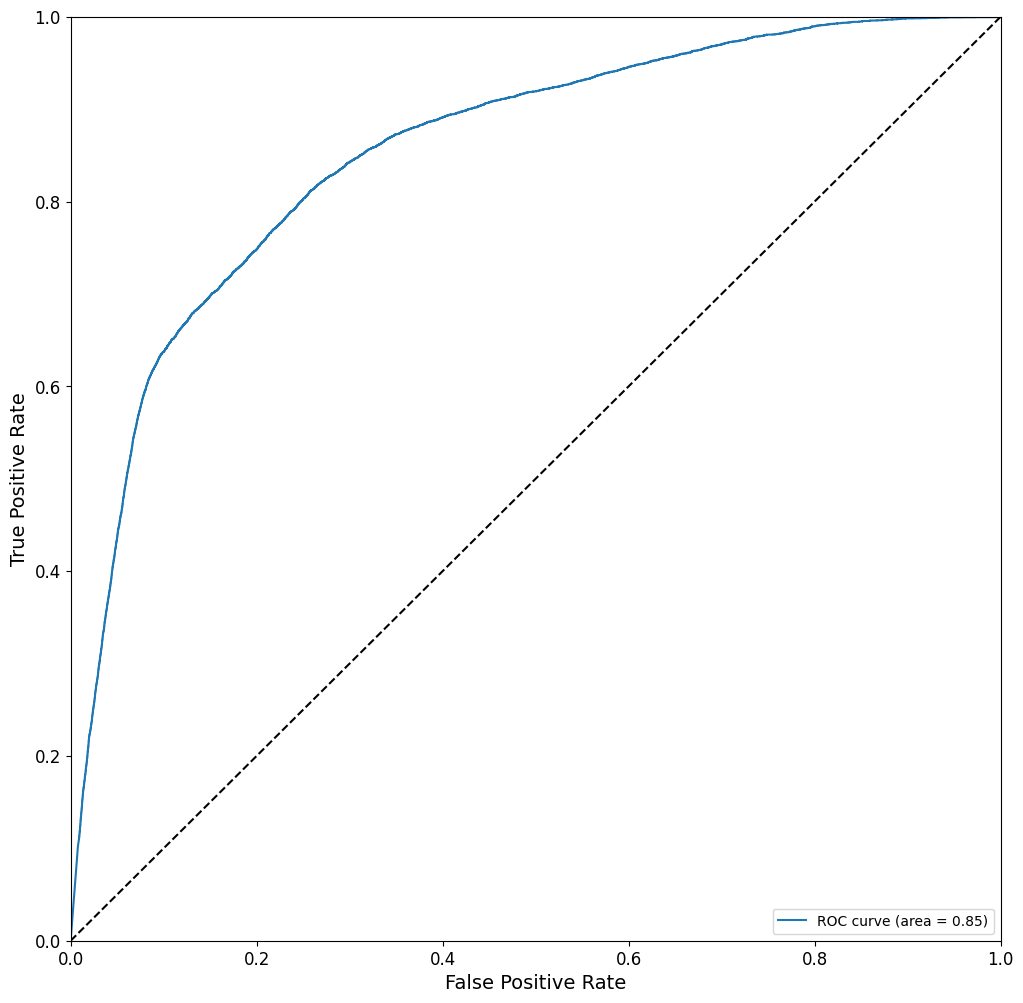

In [18]:
plt.figure(figsize = (12,12))
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

### Visualizing Delayed Flights with Dimensionality Reduction Methods

In [19]:
X_train_abbrev = X_train.iloc[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
X_test_abbrev = X_test.iloc[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(X_test.shape[0],\
                              math.ceil(X_test.shape[0]*sample_size), replace=False)

dimred_methods = {
        #Decomposition
        'pca':{'method': decomposition.PCA(n_components=3, random_state=rand)},  
        #Manifold Learning
        't-sne':{'method': manifold.TSNE(n_components=3, random_state=rand)},
    }

In [20]:
for method_name in dimred_methods.keys():
    if method_name != 'vae':
        lowdim_data = dimred_methods[method_name]['method'].\
                        fit_transform(X_test_abbrev.values[sample_idx])
    else:
        fitted_model = dimred_methods[method_name]['method'].train(num_steps=1000)
        lowdim_data = fitted_model.embed(X_test_abbrev.values[sample_idx])
        dimred_methods[method_name]['fitted'] = fitted_model
    dimred_methods[method_name]['lowdim'] = lowdim_data

In [21]:
y_names = {0:'Not Delayed', 1:'Delayed'}

/tmp/ipykernel_872/2329250337.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\


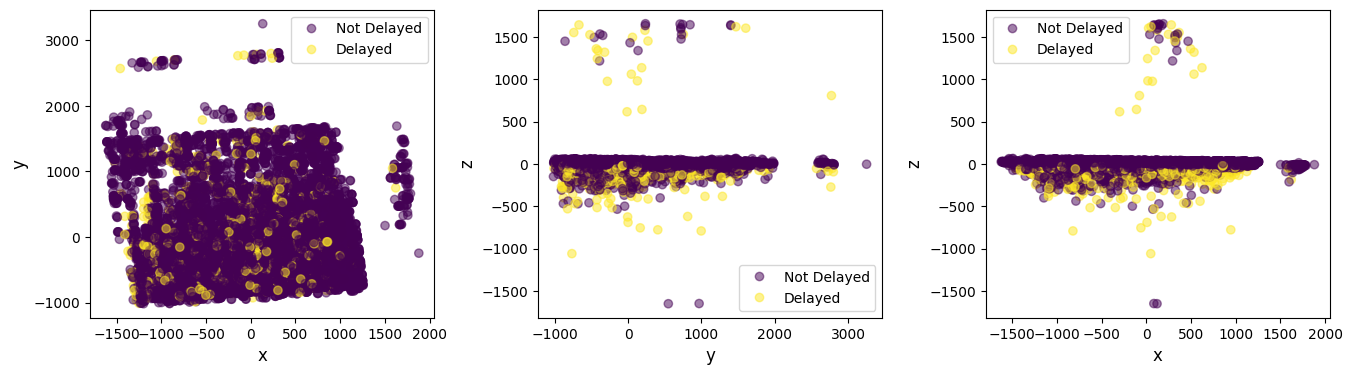

In [22]:
mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

/tmp/ipykernel_872/2336574330.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\


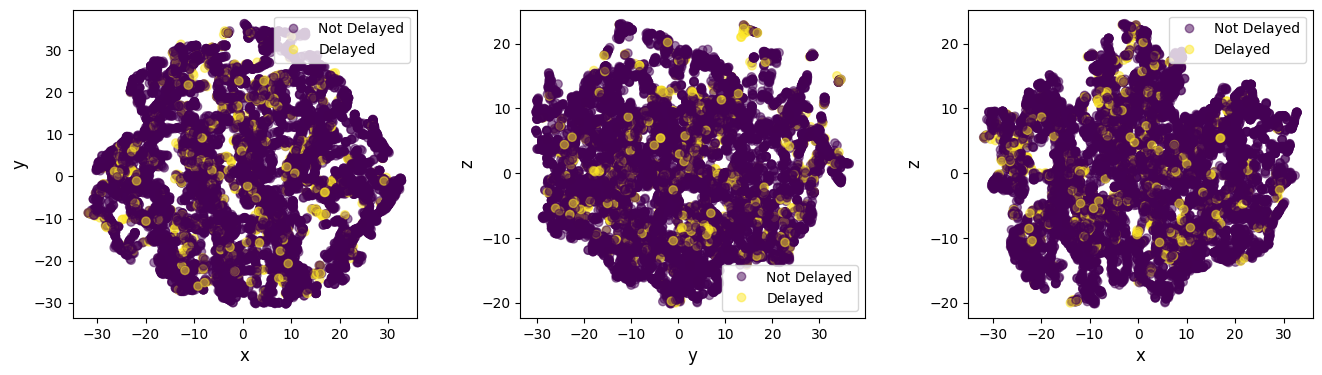

In [23]:
mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

In [24]:
y_test_class_samp = y_test_class.values[sample_idx]
y_test_pred_samp = class_models['ridge']['preds'][sample_idx]
error_vector, error_labels = mldatasets.encode_classification_error_vector(y_test_class_samp, y_test_pred_samp)

/tmp/ipykernel_872/488773323.py:3: DeprecationWarning: This method is deprecated.
  error_vector, error_labels = mldatasets.encode_classification_error_vector(y_test_class_samp, y_test_pred_samp)


/tmp/ipykernel_872/2253691292.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\


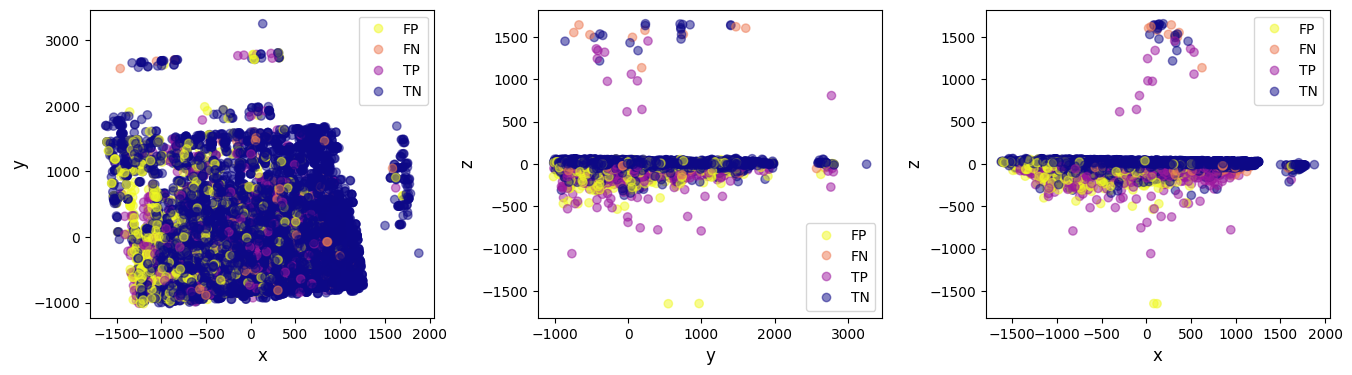

In [25]:
mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        error_vector, error_labels)

/tmp/ipykernel_872/1016749249.py:1: DeprecationWarning: This method is deprecated.
  mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\


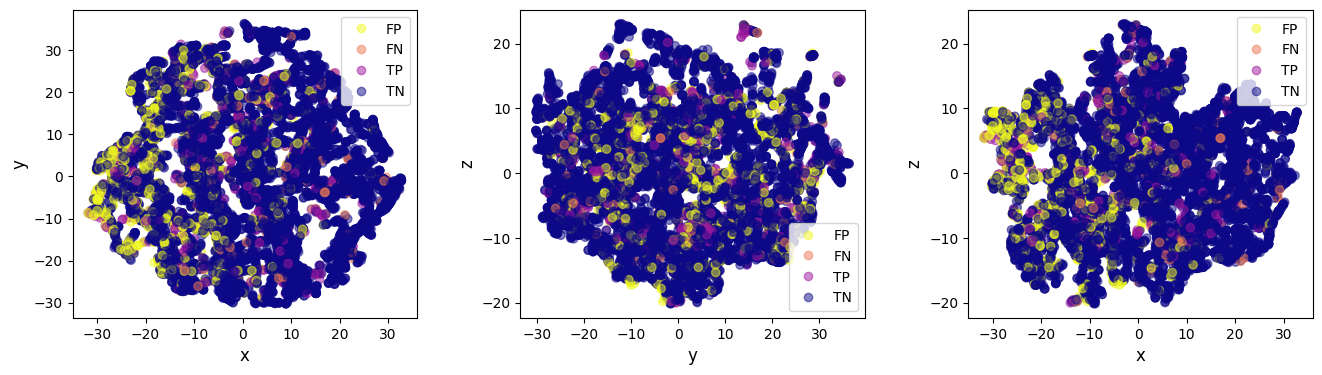

In [26]:
mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        error_vector, error_labels)

### Studying Intrinsically interpretable (White-box) models

#### Generalized Linear Models (GLMs)

GLM models allow us to build a linear relationship between the response and predictors, even though their underlying relationship is not linear. This is made possible by using a link function, which links the response variable to a linear model. Unlike Linear Regression models, the error distribution of the response variable need not be normally distributed. The errors in the response variable are assumed to follow an exponential family of distribution (i.e. normal, binomial, Poisson, or gamma distributions).

**Linear regression**

In [27]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.33208019e-03 -4.82649798e-03  5.49806142e-01 -1.57268273e-02
 -4.52798564e-01  8.10204038e-02 -6.90906448e-04  7.13522994e-03
  6.07264970e+00 -6.36255174e-04 -4.00378475e-04  9.27483208e-04
  3.86111208e-01  3.49500723e-01 -9.10147413e-01 -7.14173388e-01
 -9.30909575e-01 -9.35168913e-01 -6.36110286e-02 -1.84323264e-02
 -7.88175076e-01 -1.35097367e-01]
intercept:	0.12662661705560296


To interpret the linear regression model you just need to take coefficients and the intercept value.

In [28]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = 0.13 + 0.0043X₁ + -0.0048X₂ + 0.550X₃ + ...


In [29]:
coef_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef': coefs_lm})
print(coef_df)

                feature      coef
0          CRS_DEP_TIME  0.004332
1              DEP_TIME -0.004826
2             DEP_DELAY  0.549806
3              DEP_AFPH -0.015727
4              DEP_RFPH -0.452799
5              TAXI_OUT  0.081020
6            WHEELS_OFF -0.000691
7      CRS_ELAPSED_TIME  0.007135
8      PCT_ELAPSED_TIME  6.072650
9              DISTANCE -0.000636
10         CRS_ARR_TIME -0.000400
11             ARR_AFPH  0.000927
12             ARR_RFPH  0.386111
13            ARR_DELAY  0.349501
14        WEATHER_DELAY -0.910147
15            NAS_DELAY -0.714173
16       SECURITY_DELAY -0.930910
17  LATE_AIRCRAFT_DELAY -0.935169
18            DEP_MONTH -0.063611
19              DEP_DOW -0.018432
20           ORIGIN_HUB -0.788175
21             DEST_HUB -0.135097


All it takes to rank features is to divide the coefficients by their corresponding standard errors (its claaed t-statistic).

In [30]:
linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
linreg_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 4.401e+05
Date:                Sun, 18 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:15:19   Log-Likelihood:            -2.6288e+06
No. Observations:              764597   AIC:                         5.258e+06
Df Residuals:                  764574   BIC:                         5.258e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1266      0.197      0.642      0.521      -0.260       0.513
CRS_DEP_TIME            0.0043   6.97e-05     62.142      0.000       0.004       0.004
DEP_TIME               -0.0048   8.86e-05    -54.494      0.000      -0.005      -0.005
DEP_DELAY               0.5498      0.001    381.307      0.000       0.547       0.553
DEP_AFPH               -0.0157      0.000    -50.940      0.000      -0.016      -0.015
DEP_RFPH               -0.4528      0.017    -27.379      0.000      -0.485      -0.420
TAXI_OUT                0.0810      0.001     69.064      0.000       0.079       0.083
WHEELS_OFF             -0.0007   6.46e-05    -10.698      0.000      -0.001      -0.001
CRS_ELAPSED_TIME        0.0071      0.001     11.136      0.000       0.006       0.008
PCT_ELAPSED_TIME        6.0726      0.196     31.053      0.000       5.689       6.456
DISTANCE               -0.0006   7.75e-05     -8.211      0.000      -0.001      -0.000
CRS_ARR_TIME           -0.0004    2.1e-05    -19.033      0.000      -0.000      -0.000
ARR_AFPH                0.0009      0.000      2.901      0.004       0.000       0.002
ARR_RFPH                0.3861      0.013     30.434      0.000       0.361       0.411
ARR_DELAY               0.3495      0.001    243.843      0.000       0.347       0.352
WEATHER_DELAY          -0.9101      0.001  -1037.496      0.000      -0.912      -0.908
NAS_DELAY              -0.7142      0.001   -892.511      0.000      -0.716      -0.713
SECURITY_DELAY         -0.9309      0.005   -176.816      0.000      -0.941      -0.921
LATE_AIRCRAFT_DELAY    -0.9352      0.000  -1905.701      0.000      -0.936      -0.934
DEP_MONTH              -0.0636      0.003    -24.988      0.000      -0.069      -0.059
DEP_DOW                -0.0184      0.004     -4.265      0.000      -0.027      -0.010
ORIGIN_HUB             -0.7882      0.026    -30.659      0.000      -0.839      -0.738
DEST_HUB               -0.1351      0.025     -5.337      0.000      -0.185      -0.085
==============================================================================
Omnibus:                   193187.841   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13820940.512
Skew:                           0.193   Prob(JB):                         0.00
Kurtosis:                      23.825   Cond. No.                     9.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index().rename(columns={'index':'feature'})
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|']).\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['t_abs'])

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
17,LATE_AIRCRAFT_DELAY,-0.935169,0.000491,-1905.701085,0.000000,-0.936131,-0.934207,1905.701085
14,WEATHER_DELAY,-0.910147,0.000877,-1037.496090,0.000000,-0.911867,-0.908428,1037.496090
15,NAS_DELAY,-0.714173,0.000800,-892.510684,0.000000,-0.715742,-0.712605,892.510684
2,DEP_DELAY,0.549806,0.001442,381.307485,0.000000,0.546980,0.552632,381.307485
13,ARR_DELAY,0.349501,0.001433,243.843269,0.000000,0.346692,0.352310,243.843269
16,SECURITY_DELAY,-0.930910,0.005265,-176.815987,0.000000,-0.941229,-0.920591,176.815987
5,TAXI_OUT,0.081020,0.001173,69.064356,0.000000,0.078721,0.083320,69.064356
0,CRS_DEP_TIME,0.004332,0.000070,62.141504,0.000000,0.004195,0.004469,62.141504
1,DEP_TIME,-0.004826,0.000089,-54.494465,0.000000,-0.005000,-0.004653,54.494465
3,DEP_AFPH,-0.015727,0.000309,-50.939771,0.000000,-0.016332,-0.015122,50.939771


**Ridge regression**

It is similiar model to linear regression with additional parameter $\lambda$ which control how much shrinkage to apply. Interpretation of coefficients is the same as in linear regression.

In [32]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge})
coef_ridge_df.style.\
    background_gradient(cmap='viridis_r', low=0.3, high=0.2, axis=1)

,feature,coef_linear,coef_ridge
0,CRS_DEP_TIME,0.004332,0.004332
1,DEP_TIME,-0.004826,-0.004827
2,DEP_DELAY,0.549806,0.549782
3,DEP_AFPH,-0.015727,-0.015727
4,DEP_RFPH,-0.452799,-0.452796
5,TAXI_OUT,0.081020,0.081024
6,WHEELS_OFF,-0.000691,-0.000691
7,CRS_ELAPSED_TIME,0.007135,0.007135
8,PCT_ELAPSED_TIME,6.072650,6.068558
9,DISTANCE,-0.000636,-0.000636


The relation between value of the parameter $\lambda$ and ridge coefficients

In [33]:
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(np.concatenate((ridge.coef_[:8],ridge.coef_[9:])))

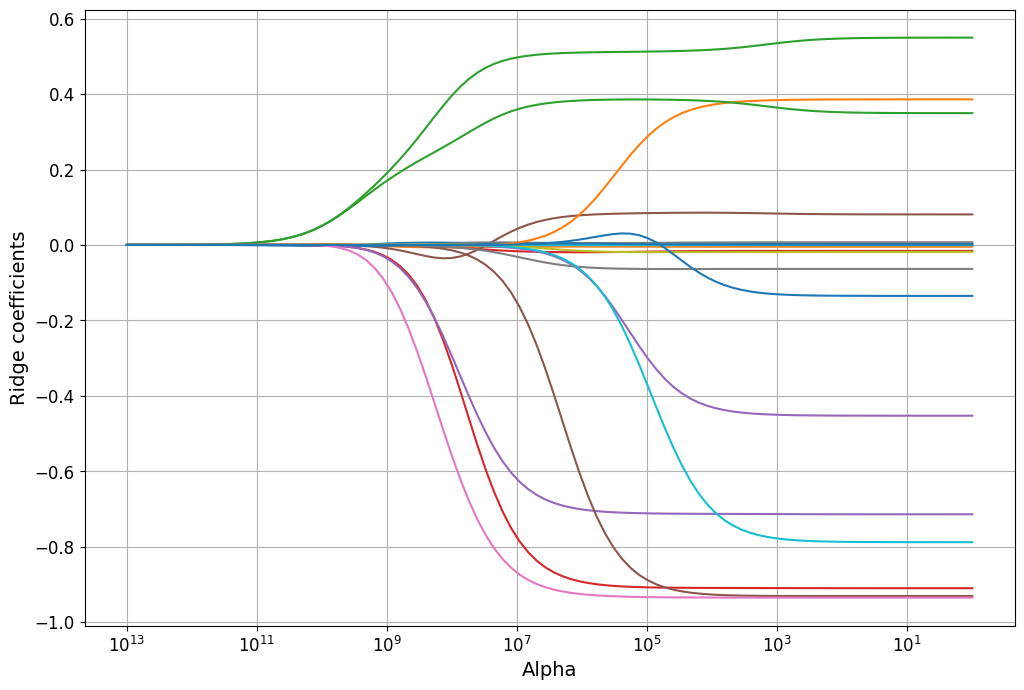

In [34]:
plt.figure(figsize = (12,8))
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Ridge coefficients', fontsize = 14)
plt.grid()
plt.show()

**Polynomial Regression**

In polynomial regression features are expanded to higher degree terms and interactions between all features. It leads to much higher number of parameters and features.

In [35]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0])

276


In [36]:
print(reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0])

254


**Logistic regression**

In [37]:
coefs_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[[-0.00036253  0.00169885  0.1171892   0.01441736 -0.0023949  -0.04202818
  -0.00204428 -0.05212118 -0.00262371  0.005823   -0.00066837 -0.00523215
  -0.00356246  0.10611787 -0.1964993  -0.18822725 -0.00656185 -0.23810311
  -0.01590949 -0.00544033  0.00061271 -0.00216514]]
intercept:	[-0.00252577]


In [39]:
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(22,) * stdv).sort_values(ascending=False)

LATE_AIRCRAFT_DELAY    5.883925
DEP_DELAY              5.187310
ARR_DELAY              4.983257
CRS_ELAPSED_TIME       4.137161
DISTANCE               3.781612
NAS_DELAY              2.593780
WEATHER_DELAY          2.053367
WHEELS_OFF             1.056066
DEP_TIME               0.874751
DEP_AFPH               0.511166
TAXI_OUT               0.414784
CRS_ARR_TIME           0.352989
ARR_AFPH               0.185026
CRS_DEP_TIME           0.181777
DEP_MONTH              0.054294
DEP_DOW                0.010872
SECURITY_DELAY         0.010756
ARR_RFPH               0.002570
DEP_RFPH               0.001353
DEST_HUB               0.001053
ORIGIN_HUB             0.000298
PCT_ELAPSED_TIME       0.000276
dtype: float64

#### Decision trees

CART (Classification and Regression Trees) is the "vanilla" algorithm for decsion tree.

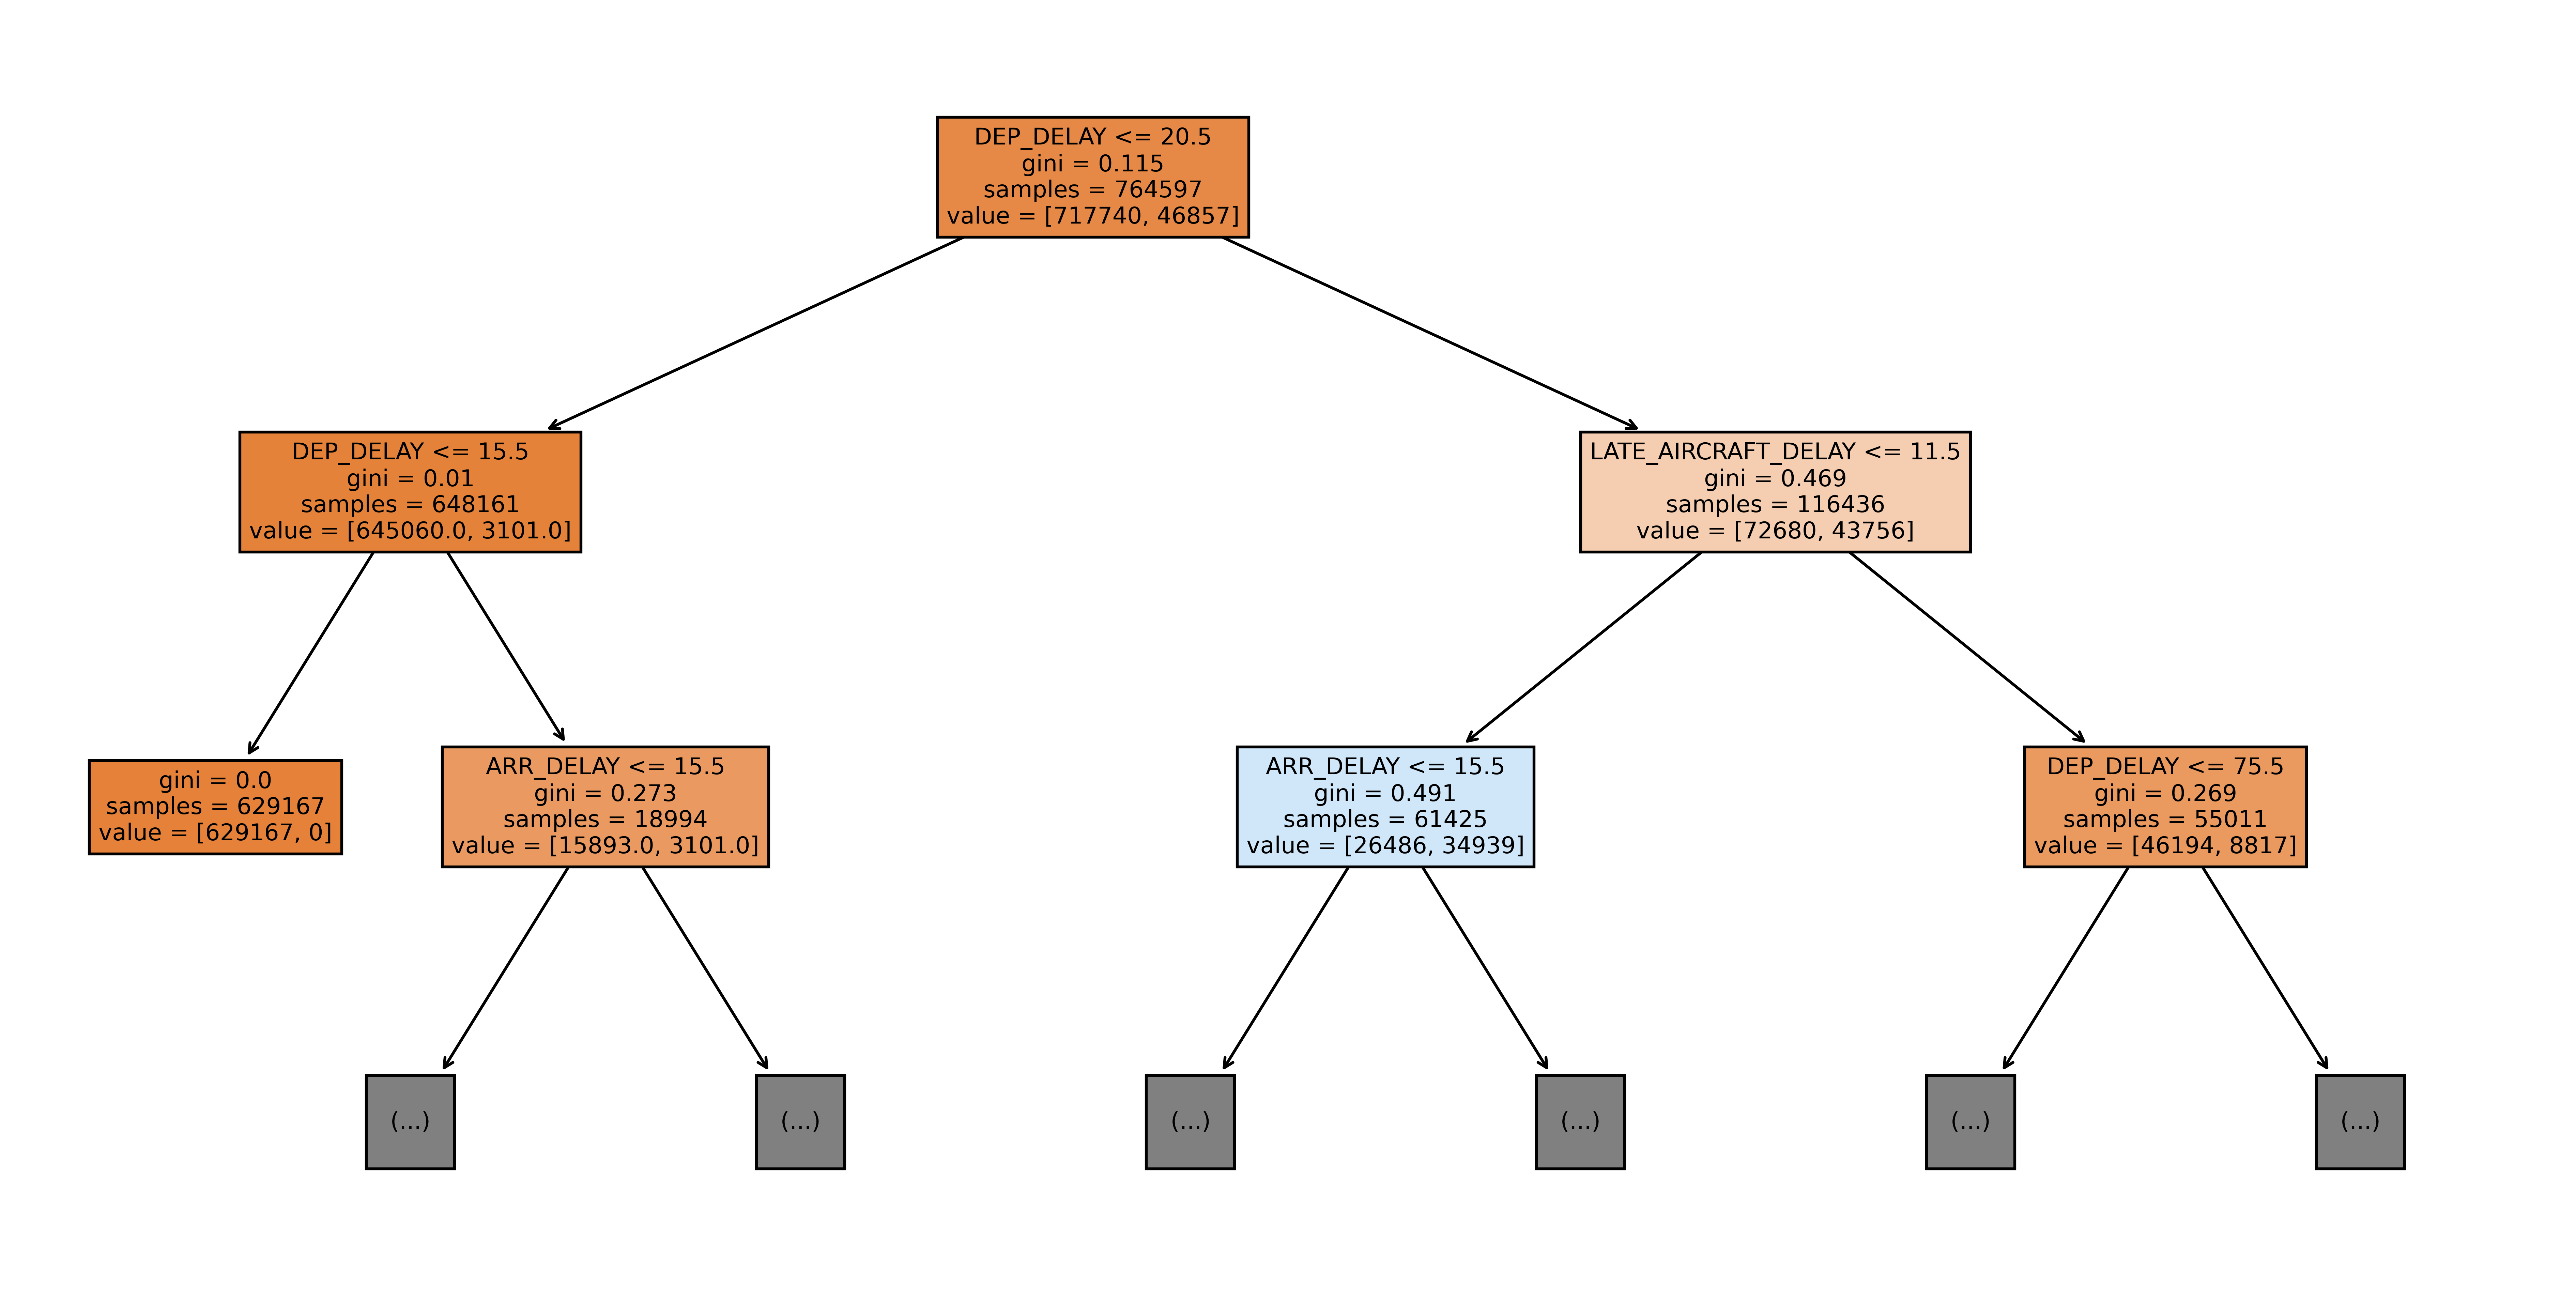

In [40]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [41]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- ARR_DELAY <= 15.50
|   |   |   |--- class: 0
|   |   |--- ARR_DELAY >  15.50
|   |   |   |--- LATE_AIRCRAFT_DELAY <= 1.50
|   |   |   |   |--- WEATHER_DELAY <= 2.00
|   |   |   |   |   |--- NAS_DELAY <= 15.50
|   |   |   |   |   |   |--- SECURITY_DELAY <= 2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- SECURITY_DELAY >  2.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- NAS_DELAY >  15.50
|   |   |   |   |   |   |--- ARR_DELAY <= 32.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- ARR_DELAY >  32.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- WEATHER_DELAY >  2.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- LATE_AIRCRAFT_DELAY >  1.50
|   |   |   |   |--- LATE_AIRCRAFT_DELAY <= 3.50
|   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |--- ARR_DELAY <= 125.00


To find the most important features sum of all relative decrease in the Gini index throughout the tree is tallied and the contribution of each feature is a percentage of this reduction

In [42]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
            sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.394810
13,ARR_DELAY,0.194460
17,LATE_AIRCRAFT_DELAY,0.191953
15,NAS_DELAY,0.106213
14,WEATHER_DELAY,0.101744
8,PCT_ELAPSED_TIME,0.005943
16,SECURITY_DELAY,0.004554
5,TAXI_OUT,0.000215
7,CRS_ELAPSED_TIME,0.000079
3,DEP_AFPH,0.000028


#### RuleFit

RuleFit is a model-class family that is hybrid between a LASSO and decision rules. These decision rules are extracted by traversing a decision tree, finding interaction efffects between features, and assigning coefficients to them based on their impact on the model.

[Description of the method](https://christophm.github.io/interpretable-ml-book/rulefit.html)

In [43]:
rulefit_df = reg_models['rulefit']['fitted'].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(by="importance", ascending=False)
rulefit_df

,rule,type,coef,support,importance
80,WEATHER_DELAY > 3.0 & DEP_DELAY > 534.5,rule,-400.270278,0.000187,5.473917
17,LATE_AIRCRAFT_DELAY,linear,-0.370909,1.000000,4.345980
49,DEP_DELAY <= 1206.0,rule,-296.562168,0.999813,4.055652
79,DEP_DELAY > 491.5 & LATE_AIRCRAFT_DELAY <= 455.5,rule,163.282504,0.000561,3.866909
13,ARR_DELAY,linear,0.112420,1.000000,3.385400
...,...,...,...,...,...
111,DEP_DELAY <= 631.0 & DEP_DELAY <= 80.5,rule,-0.110135,0.956603,0.022440
33,DEP_DELAY > 384.5,rule,0.009099,0.000935,0.000278
54,DEP_DELAY <= 48.5 & DEP_DELAY <= 534.5,rule,-0.000477,0.921811,0.000128
66,DEP_DELAY > 48.5 & DEP_DELAY <= 534.5,rule,0.000183,0.077441,0.000049


#### KNN

There are no gloabl interpretability for this method. You cna compare given example to the nearest neighbours to try to understand why given prediction was made.

In [44]:
print(X_test.loc[721043,:])

CRS_DEP_TIME            655.000000
DEP_TIME               1055.000000
DEP_DELAY               240.000000
DEP_AFPH                 90.800000
DEP_RFPH                  0.890196
TAXI_OUT                 35.000000
WHEELS_OFF             1130.000000
CRS_ELAPSED_TIME        259.000000
PCT_ELAPSED_TIME          1.084942
DISTANCE               1660.000000
CRS_ARR_TIME            914.000000
ARR_AFPH                 40.434783
ARR_RFPH                  1.064073
ARR_DELAY               262.000000
WEATHER_DELAY             0.000000
NAS_DELAY                22.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY     221.000000
DEP_MONTH                10.000000
DEP_DOW                   4.000000
ORIGIN_HUB                1.000000
DEST_HUB                  0.000000
Name: 721043, dtype: float64


In [46]:
print(y_test_class[721043])
print(class_models['knn']['preds'][X_test.index.get_loc(721043)])
print(class_models['knn']['fitted'].kneighbors(X_test.loc[721043,:].values.reshape(1,22), 7))
print(y_train_class.iloc[[105172, 571912,  73409,  89450,  77474, 705972, 706911]])

1
1
(array([[164.13250599, 187.46675449, 220.38510603, 242.25261002,
        253.9908993 , 260.81686346, 272.08187324]]), array([[105172, 571912,  73409,  89450,  77474, 705972, 381902]]))
3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64


/home/keren/.cache/pypoetry/virtualenvs/_interpretable_machine_learning_with_pytho-_K6fZrxh-py3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [47]:
print(class_models['knn']['fitted'].effective_metric_)

euclidean


#### Naive Bayes

In [48]:
print(class_models['naive_bayes']['fitted'].class_prior_)

[0.93871674 0.06128326]


Varienace of the feature when y=1

In [52]:
print(class_models['naive_bayes']['fitted'].var_)

[[2.50123026e+05 2.61324730e+05 9.21572605e+02 1.26123968e+03
  2.08339528e-01 9.58074414e+01 2.62606651e+05 6.30102550e+03
  1.13475535e-02 4.22470414e+05 2.75433641e+05 1.25314386e+03
  3.48655340e-01 1.16376500e+03 1.11234714e+02 1.91877186e+02
  2.80302201e+00 5.06561612e+02 1.17346654e+01 3.99122491e+00
  2.39015406e-01 2.34996222e-01]
 [2.60629652e+05 2.96009867e+05 1.19307931e+04 1.14839167e+03
  1.99929921e+00 1.20404927e+02 3.08568277e+05 6.29066219e+03
  1.38936741e-02 4.10198938e+05 3.28574000e+05 1.09023147e+03
  3.08997044e+00 1.19363868e+04 7.79140423e+01 1.56184090e+02
  9.12112286e-01 2.11279954e+03 1.02712368e+01 4.02943162e+00
  1.77750796e-01 2.50208354e-01]]


Mean of the feature when y=1

In [50]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.30740577e+03 1.31006271e+03 5.14196506e+00 5.45864877e+01
  1.09377996e+00 1.87120810e+01 1.33552258e+03 1.70734929e+02
  9.71131781e-01 1.01824369e+03 1.48438931e+03 5.39873058e+01
  1.09644787e+00 4.40804470e-01 7.39971299e-01 2.85434558e+00
  2.41814585e-02 4.14674395e+00 6.55045281e+00 2.95035528e+00
  6.06800513e-01 6.24199571e-01]
 [1.41305545e+03 1.48087887e+03 8.45867640e+01 6.14731036e+01
  1.25429654e+00 1.99378321e+01 1.49409412e+03 1.72229998e+02
  9.83974416e-01 1.04363666e+03 1.54821862e+03 4.26486417e+01
  1.36373798e+00 8.18500331e+01 4.50733082e-01 4.71991378e+00
  2.11281132e-02 1.40744819e+01 6.73367907e+00 3.04251232e+00
  7.69575517e-01 4.85391724e-01]]


### Discovering Newer Interpretable (Glass-box) Models

#### Explainable Boosting Machine (EBM)

#### Skoped Rules